Simulate some trials of silhouettes based on hierarchical (perceptual) chunks. Most of these silhouettes will only have one solution.

There are three conditions:
i) silhouettes composed of two chunks
ii) silhouettes composed of one chunk and two additional primitive building blocks
iii) silhouettes composed of four primitive building blocks.

We'll match the marginal probabilities of primitive building blocks by adding preferably those to ii) and iii) that are not used in a chunk.

In [9]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

## Helper functions

In [10]:
#@title Helper functions for plotting

def mkPlot_subplots_LinIdx(form_linIdx,n_grid=20,n_grid_reduced=10,title='Stim ',cols=3,rows=3):

  # uses linear indexing

  fig = plt.figure() 

  for idx_BB in np.arange(np.size(form_linIdx,0)):

    BB = np.zeros((n_grid,n_grid))
    BB[np.unravel_index(form_linIdx[idx_BB], (n_grid,n_grid), order='F')] = 1 

    fig.add_subplot(cols, rows, idx_BB+1)

    plt.imshow(mkReduceGrid(BB,n_grid_reduced), cmap='Greys')
    plt.axis('off')
    plt.title(title + str(idx_BB))

  plt.show()

def mkPlot_subplots(form_matrix,plot_idx,n_grid_reduced=10,title='Stim ',cols=5,rows=5):
  
  # uses matrix code

  fig = plt.figure() 

  fig_count = 1;
  
  for idx_BB in plot_idx:

    BB = form_matrix[idx_BB,:,:]

    fig.add_subplot(rows, cols, fig_count)

    plt.imshow(mkReduceGrid(BB,n_grid_reduced), cmap='Greys')
    plt.axis('off')
    plt.title(title + str(idx_BB))

    fig_count += 1

    # print(coord_Blocks[:,:,idx_BB])

  plt.show()


def mkPlot_stim(form_matrix,n_grid_reduced=10,title='Stim'):

  # uses matrix code

  plt.imshow(mkReduceGrid(form_matrix,n_grid_reduced), cmap='Greys')
  plt.axis('off')
  plt.title(title)
  plt.show()

In [11]:
#@title Helper function crop silhouette mkCrop()
# returns form without additional padding, also size info
def mkCrop(FORM,output='reduced'):

  min_x = np.min(np.where(np.sum(FORM,axis=0)!=0))
  max_x = np.max(np.where(np.sum(FORM,axis=0)!=0))

  min_y = np.min(np.where(np.sum(FORM,axis=1)!=0))
  max_y = np.max(np.where(np.sum(FORM,axis=1)!=0))

  FORM_crop = FORM[min_y:max_y+1,min_x:max_x+1]

  range_x = max_x - min_x + 1;
  range_y = max_y - min_y + 1;

  if output == 'full':
    return FORM_crop, range_x, range_y, min_x, max_x, min_y, max_y
  elif output == 'reduced':
    return FORM_crop

In [12]:
#@title Helper function reduce grid silhouette mkReduceGrid()
# Function to reduce grid
def mkReduceGrid(FORM,n_grid_reduced):

  FORM_crop, range_x, range_y, min_x, max_x, min_y, max_y = mkCrop(FORM,'full')

  # Form_Reduced  = FORM[min_y:max_y+1+n_grid_reduced-range_y,min_x:max_x+1+n_grid_reduced-range_x]

  x_pad = (n_grid_reduced-range_x)/2
  y_pad = (n_grid_reduced-range_y)/2

  x_pad1 = int(np.floor(x_pad))
  x_pad2 = int(np.ceil(x_pad))

  y_pad1 = int(np.floor(y_pad))
  y_pad2 = int(np.ceil(y_pad))

  Form_Reduced = np.pad(FORM_crop, ((y_pad1, y_pad2), (x_pad1, x_pad2)), 'constant', constant_values=0)

  return Form_Reduced

In [13]:
#@title Helper function overlap, size_diff, overlap, size_1, size_2 = mk_vis_overlap()


def mk_vis_overlap(Form_1,Form_2):
  # expects cropped forms

  size_1 = np.shape(Form_1)
  size_2 = np.shape(Form_2)

  if size_1[0]==size_2[0] and size_1[1]==size_2[1]:

    y_diff = 0
    x_diff = 0
    Form_xy = np.add(Form_1,Form_2)
    overlap = np.sum(Form_xy[Form_xy==2])/np.sum(Form_xy[Form_xy>0])

  else:

    y_diff = np.max([size_1[0],size_2[0]])-np.min([size_1[0],size_2[0]])
    y_pad = np.arange(0,y_diff+1)

    x_diff = np.max([size_1[1],size_2[1]])-np.min([size_1[1],size_2[1]])
    x_pad = np.arange(0,x_diff+1)

    overlap = []

    for y_move in y_pad:
      for x_move in x_pad:
        if size_1[0]<=size_2[0] and size_1[1]<=size_2[1]:
          Form_1_pad = np.pad(Form_1, ((y_move, y_diff-y_move), (0, 0)), 'constant', constant_values=0)
          Form_1_pad = np.pad(Form_1_pad, ((0, 0), (x_move, x_diff-x_move)), 'constant', constant_values=0)
          Form_2_pad = Form_2
        elif size_1[0]<=size_2[0] and size_1[1]>size_2[1]:
          Form_1_pad = np.pad(Form_1, ((y_move, y_diff-y_move), (0, 0)), 'constant', constant_values=0)
          Form_2_pad = np.pad(Form_2, ((0, 0), (x_move, x_diff-x_move)), 'constant', constant_values=0)
        elif size_1[0]>size_2[0] and size_1[1]<=size_2[1]:
          Form_1_pad = np.pad(Form_1, ((0, 0), (x_move, x_diff-x_move)), 'constant', constant_values=0)
          Form_2_pad = np.pad(Form_2, ((y_move, y_diff-y_move), (0, 0)), 'constant', constant_values=0)
        elif size_1[0]>size_2[0] and size_1[1]>size_2[1]:
          Form_1_pad = Form_1
          Form_2_pad = np.pad(Form_2, ((y_move, y_diff-y_move), (0, 0)), 'constant', constant_values=0)
          Form_2_pad = np.pad(Form_2_pad, ((0, 0), (x_move, x_diff-x_move)), 'constant', constant_values=0)

        Form_xy = np.add(Form_1_pad,Form_2_pad)

        overlap = np.append(overlap,np.sum(Form_xy[Form_xy==2])/np.sum(Form_xy[Form_xy>0]))

  overlap = np.round(overlap,2)

  # print(np.max(overlap),np.round((y_diff+x_diff)/2,2))

  # visual overlap is defined as the max overlap under all possible translations (values between 0 and 1 = identical)
  # size overlap is average size difference (0 = same size to +inf)
  return np.max(overlap), np.round((y_diff+x_diff)/2,2), overlap, size_1, size_2

In [14]:
#@title Helper function plaCement,remAinder,is_part_count = is_part()


# find out if building blocks are part of a silhouette and where

from pylab import *
from scipy.ndimage import measurements

def is_part(form_use,sil,min_block_size=3,n_grid=20,verbose=False):

  plaCement = np.zeros((100,np.size(sil,0),np.size(sil,1)))
  remAinder = np.zeros((100,np.size(sil,0),np.size(sil,1)))

  BB = np.zeros((n_grid,n_grid))
  BB[np.unravel_index(form_use, (n_grid,n_grid), order='F')] = 1
  BB = mkCrop(BB).astype(int)

  if verbose:
    print(sil)
    print(BB)

  row_idx = np.arange(0,np.size(sil,0)-np.size(BB,0)+1)
  col_idx = np.arange(0,np.size(sil,1)-np.size(BB,1)+1)

  is_part_count = 0

  for r_idx in row_idx:
    for c_idx in col_idx:
      temp = np.array(sil).astype(int)
      temp[r_idx:r_idx+np.size(BB,0),c_idx:c_idx+np.size(BB,1)] -= BB.astype(int)

      # print(temp)

      if np.all(temp!=-1):
        lw, num = measurements.label(temp)
        area = measurements.sum(temp, lw, index=arange(lw.max() + 1))
        # check if split in two clusters at most, and those cluster can be built with building blocks:
        if np.all(lw<3) and np.all(np.isin(area[1:],[min_block_size,min_block_size*2,min_block_size*3])):

          temp_placement = np.zeros_like(sil)
          temp_placement[r_idx:r_idx+np.size(BB,0),c_idx:c_idx+np.size(BB,1)] += BB.astype(int)          

          plaCement[is_part_count,:,:] = temp_placement
          remAinder[is_part_count,:,:] = temp

          is_part_count += 1

          if verbose:                        
            print(temp_placement)
            print(temp)
            print("Found " + str(is_part_count) + " part solutions.")
  
  plaCement = plaCement[0:is_part_count,:,:]
  remAinder = remAinder[0:is_part_count,:,:]

  return plaCement.astype(int),remAinder.astype(int),is_part_count

In [15]:
#@title Helper function coord_Blocks, neighBours = mkCoords()

# important: y is dominant, find minimum y coordinate (row), then minimum x (column) therein
def mkCoords(final_Coord,block_code_HBB,n_blocks=4,verbose=False):

  coord_Blocks = np.zeros((n_blocks, 3))

  neighBours = np.zeros((n_blocks, 6)) # number blocks x number of neighbours to the (left, ontop, right, below, total number of unique neighbours)


  if np.size(np.where(final_Coord==10))!=0:
    final_Coord[np.where(final_Coord==10)] = [x+1 for x in block_code_HBB[0]] # +1 because 0 = background
  if np.size(np.where(final_Coord==20))!=0:
    final_Coord[np.where(final_Coord==20)] = [x+1 for x in block_code_HBB[1]] # +1 because 0 = background

  unique_vals = np.unique(final_Coord)
  unique_vals = unique_vals[1:] # get rid of zero
  unique_vals = unique_vals.astype(int)

  block_count = 0
  for idx_blocks in unique_vals:

    coords_Block = np.where(final_Coord==idx_blocks)

    # print(coords_Block)

    coord_Blocks[block_count,1] = min(coords_Block[0])

    coord_Blocks[block_count,0] = min(coords_Block[1][np.where(coords_Block[0]==min(coords_Block[0]))])

    # for now, start counting coordinates at 1 - change to 0 later
    # coord_Blocks[block_count,1] = min(coords_Block[0])+1

    # coord_Blocks[block_count,0] = min(coords_Block[1][np.where(coords_Block[0]==min(coords_Block[0]))])+1

    coord_Blocks[block_count,2] = idx_blocks-1 # -1 because we had to add one to differentiate from background (annoyed smiley)

    # find neighbours - this is inefficient coding but hopefully easier to read that way
    # find neighbouring grid elements (this doesn't work if we are at the border somewhere):
    coords_Block_x = coords_Block[1]
    coords_Block_y = coords_Block[0]
    coords_Block_left  = [x-1 for x in coords_Block_x]
    coords_Block_ontop = [y-1 for y in coords_Block_y]
    coords_Block_right = [x+1 for x in coords_Block_x]
    coords_Block_below = [y+1 for y in coords_Block_y]
    
    # now find left, ontop, right, below neighbours, also keep track of overall (unique) neighbouers
    all_neighbours = []

    neighbours_left = (final_Coord[tuple([coords_Block_y,coords_Block_left])])
    neighbours_left = neighbours_left[neighbours_left!=0]
    neighbours_left = neighbours_left[neighbours_left!=idx_blocks]
    neighbours_left = np.unique(neighbours_left)
    if verbose:
      print("Building Block " + str(idx_blocks) + " neighbour to left: " + str(neighbours_left))    

    neighbours_ontop = (final_Coord[tuple([coords_Block_ontop,coords_Block_x])])
    neighbours_ontop = neighbours_ontop[neighbours_ontop!=0]
    neighbours_ontop = neighbours_ontop[neighbours_ontop!=idx_blocks]
    neighbours_ontop = np.unique(neighbours_ontop)
    if verbose:
      print("Building Block " + str(idx_blocks) + " neighbour to ontop: " + str(neighbours_ontop))

    neighbours_right = (final_Coord[tuple([coords_Block_y,coords_Block_right])])
    neighbours_right = neighbours_right[neighbours_right!=0]
    neighbours_right = neighbours_right[neighbours_right!=idx_blocks]
    neighbours_right = np.unique(neighbours_right)
    if verbose:
      print("Building Block " + str(idx_blocks) + " neighbour to right: " + str(neighbours_right))

    neighbours_below = (final_Coord[tuple([coords_Block_below,coords_Block_x])])
    neighbours_below = neighbours_below[neighbours_below!=0]
    neighbours_below = neighbours_below[neighbours_below!=idx_blocks]
    neighbours_below = np.unique(neighbours_below)
    if verbose:
      print("Building Block " + str(idx_blocks) + " neighbour to below: " + str(neighbours_below))

    all_neighbours = np.append(all_neighbours,neighbours_left)
    all_neighbours = np.append(all_neighbours,neighbours_ontop)
    all_neighbours = np.append(all_neighbours,neighbours_right)
    all_neighbours = np.append(all_neighbours,neighbours_below)

    all_neighbours = np.unique(all_neighbours)

    if verbose:
      print("Building Block " + str(idx_blocks) + " neighbour in total (sum): " + str(all_neighbours) + "(" + str(len(all_neighbours)) + ")")

    neighBours[block_count,0] = idx_blocks-1
    neighBours[block_count,1] = len(neighbours_left)
    neighBours[block_count,2] = len(neighbours_ontop)
    neighBours[block_count,3] = len(neighbours_right)
    neighBours[block_count,4] = len(neighbours_below)
    neighBours[block_count,5] = len(all_neighbours)

    block_count += 1

  return coord_Blocks, neighBours

In [16]:
#@title Helper function single_sol,is_part_count = find_solution()

# idea: find all possible locations of building blocks, see if they would work in principle
# see if those combinations work
def find_solution(sil,form_BB):

  n_blocks = np.size(form_BB,0)

  is_part_count = np.zeros(n_blocks)

  for idx_block in np.arange(n_blocks):
    _,_,is_part_count[idx_block] = is_part(form_BB[idx_block],sil)

  is_part_count = is_part_count.astype(int)

  single_sol = np.sum(is_part_count)==4

  return single_sol,is_part_count

In [17]:
#@title Helper function overlap_prev = findOverlap_Sil()
# 
# get overlap info one silhouette to some other/s
def findOverlap_Sil(idx_sil,idx_otherSil,Sil_Shape):

  overlap_prev = []
  for idx_other in idx_otherSil:
      overlap, _, _, _, _ = mk_vis_overlap(mkCrop(Sil_Shape[idx_sil,:,:]),mkCrop(Sil_Shape[idx_other,:,:]))
      overlap_prev = np.append(overlap_prev,overlap)

  return overlap_prev

In [18]:
#@title Helper function unique_sil = findUnique_Sil()
# 
# find unique silhouettes
def findUnique_Sil(idx_AllSil,final_Sil):

  unique_sil = []

  for idx_sil in idx_AllSil:
    
    if idx_sil>idx_AllSil[0]:
      overlap_prev = findOverlap_Sil(idx_sil,idx_AllSil[0:np.where(idx_sil==idx_AllSil)[0][0]],final_Sil)
    
    if idx_sil==idx_AllSil[0] or np.all(overlap_prev<1):
      unique_sil = np.append(unique_sil,idx_sil)

  unique_sil = unique_sil.astype(int)

  return unique_sil

## Basic Settings

In [19]:
# Settings for stim simulation
n_sim             = 180 # how many stims to simulate

do_plot = True # plot stims and solutions

n_grid_reduced = 10 # grid size of output
n_grid         = 20 # simulate in large grid, then change to n_grid_reduced for output

n_blocks       = 4 # how many primitive blocks to use in a silhouette
n_blocks_H     = 2 # how many chunks to use for silhouette
n_blocks_mix   = 3 # how many H and nH blocks in mixed silhouette

# find the middle of the big grid to place the first building block
starting_point = int(n_grid**2/2-(n_grid/2))

# define different trial types
# 0 <=> silhouette consists of 2 chunks
# 1 <=> silhouette consists of 1 chunk and 2 primitive building blocks
# 2 <=> silhouette consists of 4 primitive building blocks
trial_type = np.random.permutation(np.tile(np.array([0,1,2]), int(n_sim/3)))

chunk_type = 0
# chunk_type = 1
# chunk_type = 2
# chunk_type = 3

## Generate Basic Building Blocks

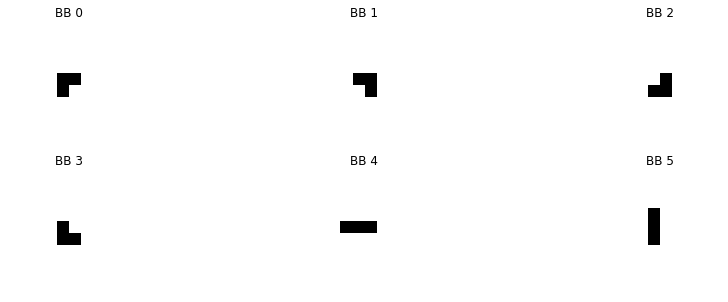

In [20]:
# define shape of primite building blocks:
form_BB = [
          [starting_point,   starting_point-1,          starting_point+(n_grid-1)],
          [starting_point-1, starting_point+(n_grid-1), starting_point+n_grid],
          [starting_point,   starting_point+n_grid,     starting_point+(n_grid-1)],
          [starting_point,   starting_point-1,          starting_point+n_grid],
          [starting_point,   starting_point+n_grid,     starting_point+n_grid*2],
          [starting_point,   starting_point-1,          starting_point-2]
          ]

if do_plot:
  plt.rcParams['figure.figsize'] = [15, 5]
  mkPlot_subplots_LinIdx(form_BB,n_grid,n_grid_reduced,'BB ',2,3)

## Generate Hierarchical Building Blocks

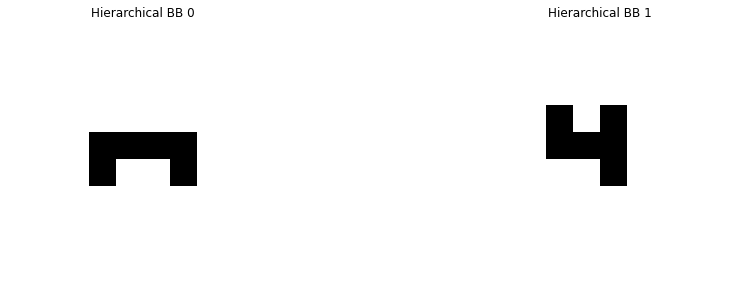

In [21]:
# define shape of some chunks:
if chunk_type==0:
  solutions_HBB  = [[0,1], [3,5]]
  form_BB_H = [
              form_BB[0] + [x + n_grid*2 for x in form_BB[1]],
              [x -1 for x in form_BB[3]] + [x + n_grid*2 for x in form_BB[5]]
              ]
  block_code_HBB = [[0,0,1,1,0,1], [3,5,3,3,5,5]]

elif chunk_type==1:
  solutions_HBB  = [[4,5], [3,2]]

  form_BB_H = [
              form_BB[5] + [x - n_grid -3 for x in form_BB[4]],
              form_BB[2] + [x + n_grid -2  for x in form_BB[3]]
              ]
  block_code_HBB = [[4,4,4,5,5,5], [3,3,3,2,2,2]]

elif chunk_type==2:
  solutions_HBB  = [[1,4], [2,0]]

  form_BB_H = [
              form_BB[4] + [x - 1 for x in form_BB[1]],
              form_BB[2] + [x + n_grid*2 -1  for x in form_BB[0]]
              ]
  block_code_HBB = [[1,1,1,4,4,4], [0,0,2,0,2,2]]

elif chunk_type==3:
  solutions_HBB  = [[5,1], [4,3]]

  form_BB_H = [
              form_BB[5] + [x + n_grid for x in form_BB[1]],
              form_BB[4] + [x + n_grid -1  for x in form_BB[3]]
              ]
  block_code_HBB = [[5,5,1,1,5,1], [3,3,3,4,4,4]]


if do_plot:
  plt.rcParams['figure.figsize'] = [15, 5]
  mkPlot_subplots_LinIdx(form_BB_H,n_grid,n_grid_reduced,'Hierarchical BB ',1,np.size(form_BB_H,0))

# Note: finding block_code_HBB is a bit of a hack and is done via
# Form_find = np.zeros((n_grid,n_grid))
# Form_find[np.unravel_index(form_BB_H[0], (n_grid,n_grid), order='F')] = 1
# Form_find[np.unravel_index(form_BB_H[1], (n_grid,n_grid), order='F')] = 1
# Form_find[np.where(Form_find==1)] = [1, 2, 3, 4, 5, 6]
# print(Form_find)

## Generate a shape

In [31]:
# Helper function final_Form, final_Coord = simTrial()
def simTrial(n_grid,blocks,form_block,block_code,verbose=False,):

  # Input:
  # n_grid: size of grid
  # blocks: which blocks to use, expects array and then goes through sequentially
  # form_block: shape of blocks, called by 'blocks'
  # 
  # Output:
  # Final shape in grid
  # Final shape in coordinate form
  # idea is to work with linear indices on grid

  n_blocks = np.size(blocks,0)

  # initialise form
  final_Form = np.zeros((n_grid,n_grid))

  # initialise coordinates
  final_Coord = np.zeros((n_grid,n_grid))
 
  #start with first building block
  current_form = np.array(form_block[blocks[0]])  

  # obtain coordinate information in reduced grid
  final_Coord[np.unravel_index(current_form, (n_grid,n_grid), order='F')] = block_code[0] # move from linear index into grid (matrix)

  #specify bounds on grid - to control we are not moving outside of grid
  up_bound    = np.arange(n_grid**2-(n_grid-1),n_grid)
  low_bound   = np.arange((n_grid-1),n_grid**2,n_grid)
  left_bound  = np.arange(n_grid)
  right_bound = np.arange(n_grid**2-n_grid,n_grid**2)

  for idx_BB in np.arange(1,np.size(blocks,0)):

    # find possible adjacent starting points for next BB
    adj_points = np.unique(np.array([current_form-n_grid, current_form-1, current_form+n_grid, current_form+1])) # all adjacent pixels left, ontop, right, or below
    adj_points = adj_points[~np.isin(adj_points,current_form)] # can't move 'into' silhouette   
    adj_points = adj_points[adj_points>=0] # can't move out of linear grid  
    adj_points = adj_points[adj_points<=n_grid**2] # can't move out of linear grid    
    
    # now try them in random order as connection points for next building block:
    adj_points = np.random.permutation(adj_points)

    built = False
    idx_adj = 0
    
    while built == False:

        # necessary because it's all randomised, ideally should go through all possible combinations
        if idx_adj==len(adj_points):
          idx_adj = 0

        # put left bottom part (random choice) of next BB onto chosen adjacent point
        conn_point_block = np.random.choice(form_block[blocks[idx_BB]],1)

        next_block = np.array(form_block[blocks[idx_BB]]) + adj_points[idx_adj] - int(conn_point_block)

        # check if we didn't move outside of grid
        if (
            all(np.isin(next_block,np.arange(0,n_grid**2))) and # did we move outside of grid?
            all(~np.isin(next_block,current_form)) and # is new BB overlapping with prev shape (can happen due to weird shapes of BBs)
            ~(any(np.isin(low_bound,next_block)) and any(np.isin(up_bound,next_block))) and # did we accidentally move from bottom to top of box (linear idx!)
            ~(any(np.isin(left_bound,next_block)) and any(np.isin(right_bound,next_block))) # did we accidentally move from left to right of box (linear idx!)
           ):
          
           current_form = np.concatenate((current_form, next_block), axis=0) # concatenate new block

           # obtain coordinate information in reduced grid
           final_Coord[np.unravel_index(next_block, (n_grid,n_grid), order='F')] = block_code[idx_BB] # move from linear index into grid (matrix)           

           if verbose:
             print('Done, it took ' + str(idx_adj+1) + ' attempts.')

           built = True
           
        else:
            
            idx_adj += 1

  final_Form[np.unravel_index(current_form, (n_grid,n_grid), order='F')] = 1 # move from linear index into grid (matrix)

  return final_Form, final_Coord#, final_Form_minesweep, final_Coord_minesweep

## Check some stims

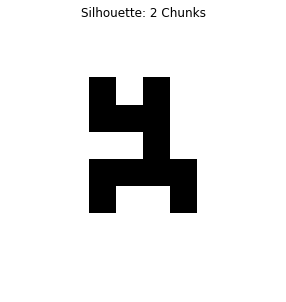

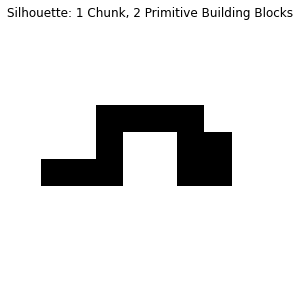

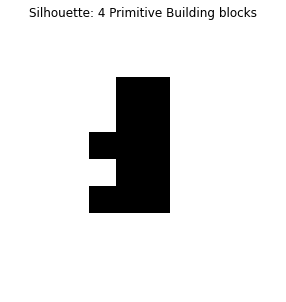

In [23]:
# i) hierarchies (2 chunks)
use_blocks = np.random.choice(np.arange(np.size(form_BB_H,0)), size=n_blocks_H, replace=False)
use_blocks = np.random.permutation(use_blocks)

# We count building blocks starting from 0, but have to increase the cound by +1 because on the grid, 0 = background
# Also, as a convention, hierarchical building blocks are counted in steps of ten (10,20,30,...), basic building blocks in integers <10 (1,2,3,..)
block_code = [(x+1)*10 for x in use_blocks] # +1 because 0 = background, *10 identifies hierarchies

final_Form, final_Coord = simTrial(n_grid,use_blocks,form_BB_H,block_code)

if do_plot:
  plt.rcParams['figure.figsize'] = [15, 5]
  mkPlot_stim(final_Form,n_grid_reduced,'Silhouette: 2 Chunks')

# ii) mixed (1 chunk, 2 building blocks)
use_HBB    = np.random.choice(np.size(form_BB_H,0),1)
unused_BBs = np.setdiff1d(np.arange(np.size(form_BB,0)),np.array(solutions_HBB))
unused_BBs = np.random.permutation(unused_BBs)

use_form_BB = [form_BB_H[idx] for idx in use_HBB] + [form_BB[idx] for idx in unused_BBs]

use_blocks = np.concatenate((use_HBB, unused_BBs), axis=0)

# We count building blocks starting from 0, but have to increase the cound by +1 because on the grid, 0 = background
# Also, as a convention, hierarchical building blocks are counted in steps of ten (10,20,30,...), basic building blocks in integers <10 (1,2,3,..)
block_code = [(x+1) for x in use_blocks] # +1 because 0 = background
block_code[0] = block_code[0]*10

final_Form, final_Coord = simTrial(n_grid,np.arange(np.size(use_blocks,0)),use_form_BB,block_code)

if do_plot:
  plt.rcParams['figure.figsize'] = [15, 5]
  mkPlot_stim(final_Form,n_grid_reduced,'Silhouette: 1 Chunk, 2 Primitive Building Blocks')

# iii) no hierarchies (4 primitive building blocks)
use_blocks = np.random.choice(np.arange(np.size(form_BB,0)), size=n_blocks, replace=False)
use_blocks = np.random.permutation(use_blocks)

# We count building blocks starting from 0, but have to increase the cound by +1 because on the grid, 0 = background
# Also, as a convention, hierarchical building blocks are counted in steps of ten (10,20,30,...), basic building blocks in integers <10 (1,2,3,..)
block_code = [(x+1) for x in use_blocks] # +1 because 0 = background

final_Form, final_Coord = simTrial(n_grid,use_blocks,form_BB,block_code)

if do_plot:
  plt.rcParams['figure.figsize'] = [15, 5]
  mkPlot_stim(final_Form,n_grid_reduced,'Silhouette: 4 Primitive Building blocks')

## Flexibly generate different sizes

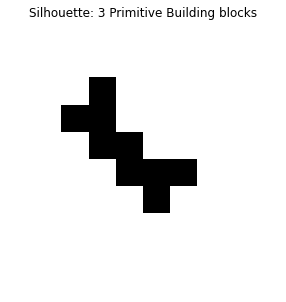

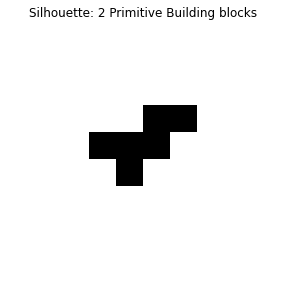

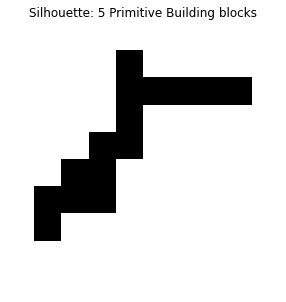

In [32]:
#  It's quite flexible, you can also build a shape with three building blocks:
use_blocks = [0,1,2]
block_code = [(x+1) for x in use_blocks] # +1 because 0 = background

final_Form, final_Coord = simTrial(n_grid,use_blocks,form_BB,block_code)

if do_plot:
  plt.rcParams['figure.figsize'] = [15, 5]
  mkPlot_stim(final_Form,n_grid_reduced,'Silhouette: 3 Primitive Building blocks')

#  or just two:
use_blocks = [0,1]
block_code = [(x+1) for x in use_blocks] # +1 because 0 = background

final_Form, final_Coord = simTrial(n_grid,use_blocks,form_BB,block_code)

if do_plot:
  plt.rcParams['figure.figsize'] = [15, 5]
  mkPlot_stim(final_Form,n_grid_reduced,'Silhouette: 2 Primitive Building blocks')

#  or five:
use_blocks = [0,1,2,3,4]
block_code = [(x+1) for x in use_blocks] # +1 because 0 = background

final_Form, final_Coord = simTrial(n_grid,use_blocks,form_BB,block_code)

if do_plot:
  plt.rcParams['figure.figsize'] = [15, 5]
  mkPlot_stim(final_Form,n_grid_reduced,'Silhouette: 5 Primitive Building blocks')

## Simulate (a lot of) 2 chunk shapes

Trial 0 of 500 done.
Bingo, found another. Now have 2
Bingo, found another. Now have 3
Bingo, found another. Now have 4
Bingo, found another. Now have 5
Bingo, found another. Now have 6
Bingo, found another. Now have 7
Bingo, found another. Now have 8
Bingo, found another. Now have 9
Bingo, found another. Now have 10
Bingo, found another. Now have 11
Bingo, found another. Now have 12
Bingo, found another. Now have 13
Bingo, found another. Now have 14
Bingo, found another. Now have 15
Bingo, found another. Now have 16
Bingo, found another. Now have 17
Bingo, found another. Now have 18
Bingo, found another. Now have 19
Trial 100 of 500 done.
Trial 200 of 500 done.
Trial 300 of 500 done.
Trial 400 of 500 done.


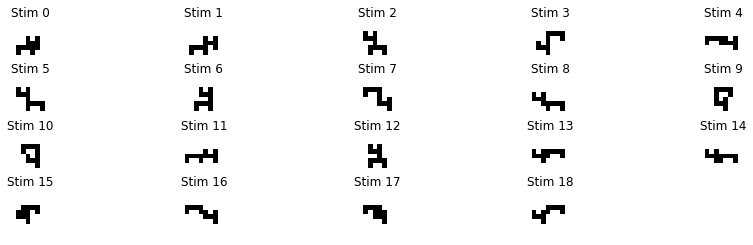

In [ ]:
# Find 2 chunk stims
# Aim here is to try to find all allowable connections of 2 chunk silhouettes
# It's implemented as a random search because the exact solutions vary with every chunk spcification, and because I'm lazy

n_sim = 500

final_Sil_2chunk    = np.zeros((n_sim,n_grid_reduced,n_grid_reduced))
final_Coord_2chunk  = np.zeros((n_sim,n_grid_reduced,n_grid_reduced))
solutions_2chunk    = np.zeros((n_sim,4))
coord_Blocks_2chunk = np.zeros((n_sim,4,4))

idx_unique = 0

for idx_sim in np.arange(n_sim):

  use_blocks = np.random.choice(np.arange(np.size(form_BB_H,0)), size=n_blocks_H, replace=False) # random.choice not neccessary here but will be when more than 2 chunks

  block_code = [(x+1)*10 for x in use_blocks] # +1 because 0 = background, *10 identifies hierarchies

  single_sol = False
  while not single_sol: # ensure silhouette only has one solution
    Sil_Trial, final_Coord = simTrial(n_grid,use_blocks,form_BB_H, block_code) # get silhouette
    single_sol = find_solution(mkCrop(Sil_Trial),form_BB)

  # Sil_Trial, final_Coord = simTrial(n_grid,use_blocks,form_BB_H, block_code) # get silhouette

  if idx_unique==0:
    final_Sil_2chunk[idx_unique,:,:] = mkReduceGrid(Sil_Trial,n_grid_reduced)

    final_Coord = mkReduceGrid(final_Coord,n_grid_reduced)
    
    coord_Blocks_2chunk[idx_unique,:,0:3], _ = mkCoords(final_Coord,block_code_HBB)
    coord_Blocks_2chunk[idx_unique,:,3]      = idx_unique

    final_Coord_2chunk[idx_unique,:,:] = final_Coord

    solutions_2chunk[idx_unique,:]   = np.concatenate((solutions_HBB[use_blocks[0]], solutions_HBB[use_blocks[1]]), axis=0)

    idx_unique += 1

  else:

    final_Sil_2chunk[idx_unique,:,:] = mkReduceGrid(Sil_Trial,n_grid_reduced)

    overlap_prev = findOverlap_Sil(idx_unique,np.arange(idx_unique),final_Sil_2chunk)
    if np.all(overlap_prev<1):
      final_Coord = mkReduceGrid(final_Coord,n_grid_reduced)
      
      coord_Blocks_2chunk[idx_unique,:,0:3], _ = mkCoords(final_Coord,block_code_HBB)
      coord_Blocks_2chunk[idx_unique,:,3]      = idx_unique

      final_Coord_2chunk[idx_unique,:,:] = final_Coord

      solutions_2chunk[idx_unique,:]   = np.concatenate((solutions_HBB[use_blocks[0]], solutions_HBB[use_blocks[1]]), axis=0)            

      idx_unique += 1 
      print("Bingo, found another. Now have " + str(idx_unique))      

  if idx_sim%100 == 0:
    print('Trial ' + str(idx_sim) + ' of ' + str(n_sim) + ' done.')

final_Sil_2chunk    = final_Sil_2chunk[0:idx_unique,:,:].astype(int)
final_Coord_2chunk  = final_Coord_2chunk[0:idx_unique,:,:].astype(int)
solutions_2chunk    = solutions_2chunk[0:idx_unique,:].astype(int)
coord_Blocks_2chunk = coord_Blocks_2chunk[0:idx_unique,:,:].astype(int)

mkPlot_subplots(final_Sil_2chunk,np.arange(idx_unique),10,'Stim ',5,5)

# np.save("final_Sil_2chunk.npy", final_Sil_2chunk)
# np.save("final_Coord_2chunk.npy", final_Coord_2chunk)
# np.save("solutions_2chunk.npy", solutions_2chunk)
# np.save("coord_Blocks_2chunk.npy", coord_Blocks_2chunk)

## Simulate (a lot of) 1 chunk shapes

In [ ]:
# Find 1 chunk stims
# Motivation identical to 2 chunk shapes

n_sim = 200

final_Sil_1chunk    = np.zeros((n_sim,n_grid_reduced,n_grid_reduced))
final_Coord_1chunk  = np.zeros((n_sim,n_grid_reduced,n_grid_reduced))
solutions_1chunk    = np.zeros((n_sim,4))
coord_Blocks_1chunk = np.zeros((n_sim,4,4))

idx_unique = 0

for idx_sim in np.arange(n_sim):

  # introduce bias to match marginal probs of BBs
  use_HBB    = np.random.choice(np.size(form_BB_H,0),1) # randomly choose one chunk
  unused_BBs = np.setdiff1d(np.arange(np.size(form_BB,0)),np.array(solutions_HBB)) # choose the primitive blocks that are not used in the chunks
  unused_BBs = np.random.permutation(unused_BBs)

  use_form_BB = [form_BB_H[idx] for idx in use_HBB] + [form_BB[idx] for idx in unused_BBs] # put the shapes of the blocks we want to use in this trial together

  use_blocks = np.concatenate((use_HBB, unused_BBs), axis=0)

  block_code = [(x+1) for x in use_blocks] # +1 because 0 = background
  block_code[0] = block_code[0]*10 # *10 identifies hierarchies

  single_sol = False
  while not single_sol: # ensure silhouette only has one solution
    Sil_Trial, final_Coord = simTrial(n_grid,np.arange(np.size(use_blocks,0)),use_form_BB,block_code) # get silhouette    
    single_sol = find_solution(mkCrop(Sil_Trial),form_BB)

  # Sil_Trial, final_Coord = simTrial(n_grid,use_blocks,form_BB_H, block_code) # get silhouette

  if idx_unique==0:
    final_Sil_1chunk[idx_unique,:,:] = mkReduceGrid(Sil_Trial,n_grid_reduced)

    final_Coord = mkReduceGrid(final_Coord,n_grid_reduced)

    coord_Blocks_1chunk[idx_unique,:,0:3], _ = mkCoords(final_Coord,block_code_HBB)
    coord_Blocks_1chunk[idx_unique,:,3]      = idx_unique

    final_Coord_1chunk[idx_unique,:,:] = final_Coord

    solutions_1chunk[idx_unique,:]   = np.concatenate((solutions_HBB[use_blocks[0]], use_blocks[1:]), axis=0)

    idx_unique += 1

  else:

    final_Sil_1chunk[idx_unique,:,:] = mkReduceGrid(Sil_Trial,n_grid_reduced)

    overlap_prev = findOverlap_Sil(idx_unique,np.arange(idx_unique),final_Sil_1chunk)
    if np.all(overlap_prev<1):
      final_Coord = mkReduceGrid(final_Coord,n_grid_reduced)

      coord_Blocks_1chunk[idx_unique,:,0:3], _ = mkCoords(final_Coord,block_code_HBB)
      coord_Blocks_1chunk[idx_unique,:,3]      = idx_unique

      final_Coord_1chunk[idx_unique,:,:] = final_Coord

      solutions_1chunk[idx_unique,:]   = np.concatenate((solutions_HBB[use_blocks[0]], use_blocks[1:]), axis=0)           

      idx_unique += 1 
      # print("Bingo, found another. Now have " + str(idx_unique))      

  if idx_sim%100 == 0:
    print('Trial ' + str(idx_sim) + ' of ' + str(n_sim) + ' done.')
    print("Found " + str(idx_unique) + " so far.")

final_Sil_1chunk    = final_Sil_1chunk[0:idx_unique,:,:].astype(int)
final_Coord_1chunk  = final_Coord_1chunk[0:idx_unique,:,:].astype(int)
solutions_1chunk    = solutions_1chunk[0:idx_unique,:].astype(int)
coord_Blocks_1chunk = coord_Blocks_1chunk[0:idx_unique,:,:].astype(int)

mkPlot_subplots(final_Sil_1chunk,np.arange(idx_unique),10,'Stim ',5,5)
print("Found " + str(idx_unique) + " in total.")

# np.save("final_Sil_1chunk.npy", final_Sil_1chunk)
# np.save("final_Coord_1chunk.npy", final_Coord_1chunk)
# np.save("solutions_1chunk.npy", solutions_1chunk)
# np.save("coord_Blocks_1chunk.npy", coord_Blocks_1chunk)

Trial 0 of 200 done.
Found 1 so far.
Trial 100 of 200 done.
Found 91 so far.
Found 164 in total.


## Simulate (a lot of) random stims

In [ ]:
# Find random stims
n_sim = 200

final_Sil_random    = np.zeros((n_sim,n_grid_reduced,n_grid_reduced))
final_Coord_random  = np.zeros((n_sim,n_grid_reduced,n_grid_reduced))
solutions_random    = np.zeros((n_sim,4))
coord_Blocks_random = np.zeros((n_sim,4,4))

idx_unique = 0

for idx_sim in np.arange(n_sim):

  # introduce bias to match marginal probs of BBs
  unused_BBs = np.setdiff1d(np.arange(np.size(form_BB,0)),np.array(solutions_HBB)) # choose the primitive blocks that are not used in the chunks
  add_BBs    = np.random.choice(np.setdiff1d(np.array(solutions_HBB),unused_BBs),2,False) # choose two more primitive blocks

  use_blocks    = np.random.permutation(np.concatenate((unused_BBs, add_BBs), axis=0))

  block_code = [(x+1) for x in use_blocks] # +1 because 0 = background

  single_sol = False
  noChunks = False
  while (not single_sol) and (not noChunks): # ensure silhouette only has one solution
    Sil_Trial, final_Coord = simTrial(n_grid,use_blocks,form_BB,block_code) # get silhouette
    _,_,part_count_0 = is_part(form_BB_H[0],Sil_Trial,6)
    _,_,part_count_1 = is_part(form_BB_H[1],Sil_Trial,6)
    if part_count_0==0 and part_count_1==0:
      noChunks = True
    single_sol = find_solution(mkCrop(Sil_Trial),form_BB)

  # Sil_Trial, final_Coord = simTrial(n_grid,use_blocks,form_BB_H, block_code) # get silhouette

  if idx_unique==0:
    final_Sil_random[idx_unique,:,:] = mkReduceGrid(Sil_Trial,n_grid_reduced)

    final_Coord = mkReduceGrid(final_Coord,n_grid_reduced)

    coord_Blocks_random[idx_unique,:,0:3], _ = mkCoords(final_Coord,block_code_HBB)
    coord_Blocks_random[idx_unique,:,3]      = idx_unique

    final_Coord_random[idx_unique,:,:] = final_Coord

    solutions_random[idx_unique,:]   = use_blocks

    idx_unique += 1
  else:

    final_Sil_random[idx_unique,:,:] = mkReduceGrid(Sil_Trial,n_grid_reduced)

    overlap_prev = findOverlap_Sil(idx_unique,np.arange(idx_unique),final_Sil_random)
    if np.all(overlap_prev<1):
      final_Coord = mkReduceGrid(final_Coord,n_grid_reduced)

      coord_Blocks_random[idx_unique,:,0:3], _ = mkCoords(final_Coord,block_code_HBB)
      coord_Blocks_random[idx_unique,:,3].     = idx_unique

      final_Coord_random[idx_unique,:,:] = final_Coord

      solutions_random[idx_unique,:]   = use_blocks          

      idx_unique += 1 
      # print("Bingo, found another. Now have " + str(idx_unique))      

  if idx_sim%100 == 0:
    print('Trial ' + str(idx_sim) + ' of ' + str(n_sim) + ' done.')
    print("Found " + str(idx_unique) + " so far.")

final_Sil_random    = final_Sil_random[0:idx_unique,:,:].astype(int)
final_Coord_random  = final_Coord_random[0:idx_unique,:,:].astype(int)
solutions_random    = solutions_random[0:idx_unique,:].astype(int)
coord_Blocks_random = coord_Blocks_random[0:idx_unique,:,:].astype(int)

print("Found " + str(idx_unique) + " in total.")

# np.save("final_Sil_random.npy", final_Sil_random)
# np.save("final_Coord_random.npy", final_Coord_random)
# np.save("solutions_random.npy", solutions_random)
# np.save("coord_Blocks_random.npy", coord_Blocks_random)

Trial 0 of 200 done.
Found 1 so far.
Trial 100 of 200 done.
Found 101 so far.
Found 198 in total.


## Get stims for experiment

2 Chunk Stims:


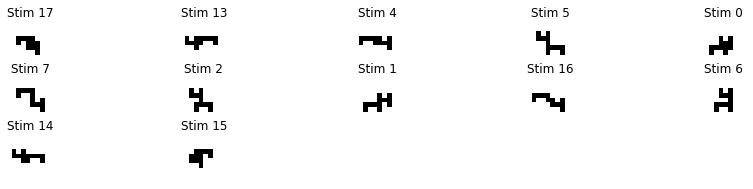

1 Chunk Stims:


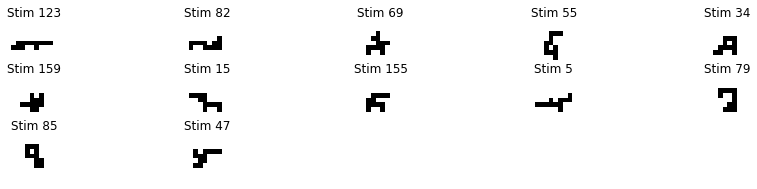

Random Stims:


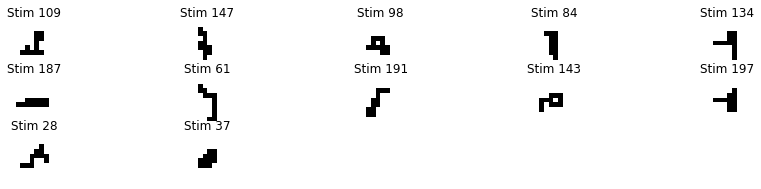

In [ ]:
# simulate actual experiment
# We've simulated lots of candidate silhouettes above, now let's just sample a fixed number per trial type

n_sim = len(trial_type)

final_Sil    = np.zeros((n_sim,n_grid_reduced,n_grid_reduced))
solutions    = np.zeros((n_sim,4))
coord_Blocks = np.zeros((n_sim,4,4))

final_Sil    = final_Sil.astype(int)
solutions    = solutions.astype(int)
coord_Blocks = coord_Blocks.astype(int)

n_stims_use = 12
stims_use = np.zeros_like(trial_type)

# find 2 chunk silhouettes
mainTask_sil_2chunk = np.random.choice(np.size(final_Sil_2chunk,0),n_stims_use,False)
print("2 Chunk Stims:")
mkPlot_subplots(final_Sil_2chunk,mainTask_sil_2chunk,10,'Stim ',5,5)

mainTask_sil_2chunk = np.random.permutation(np.tile(mainTask_sil_2chunk, 
                                            int(len(trial_type[trial_type==0])/n_stims_use)))
stims_use[trial_type==0] = mainTask_sil_2chunk
# print(stims_use)

# find 1 chunk silhouettes
mainTask_sil_1chunk = np.random.choice(np.size(final_Sil_1chunk,0),n_stims_use,False)
print("1 Chunk Stims:")
mkPlot_subplots(final_Sil_1chunk,mainTask_sil_1chunk,10,'Stim ',5,5)
mainTask_sil_1chunk = np.random.permutation(np.tile(mainTask_sil_1chunk, 
                                            int(len(trial_type[trial_type==1])/n_stims_use)))
stims_use[trial_type==1] = mainTask_sil_1chunk
# print(stims_use)

# find random silhouettes
mainTask_sil_random = np.random.choice(np.size(final_Sil_random,0),n_stims_use,False)
print("Random Stims:")
mkPlot_subplots(final_Sil_random,mainTask_sil_random,10,'Stim ',5,5)
mainTask_sil_random = np.random.permutation(np.tile(mainTask_sil_random, 
                                            int(len(trial_type[trial_type==2])/n_stims_use)))
stims_use[trial_type==2] = mainTask_sil_random
# print(stims_use)

final_Sil[trial_type==0,:,:] = final_Sil_2chunk[mainTask_sil_2chunk,:,:].astype(int)
final_Sil[trial_type==1,:,:] = final_Sil_1chunk[mainTask_sil_1chunk,:,:].astype(int)
final_Sil[trial_type==2,:,:] = final_Sil_random[mainTask_sil_random,:,:].astype(int)

solutions[trial_type==0,:] = solutions_2chunk[mainTask_sil_2chunk,:].astype(int)
solutions[trial_type==1,:] = solutions_1chunk[mainTask_sil_1chunk,:].astype(int)
solutions[trial_type==2,:] = solutions_random[mainTask_sil_random,:].astype(int)

coord_Blocks[trial_type==0,:,:] = coord_Blocks_2chunk[mainTask_sil_2chunk,:,:].astype(int)
coord_Blocks[trial_type==1,:,:] = coord_Blocks_1chunk[mainTask_sil_1chunk,:,:].astype(int)
coord_Blocks[trial_type==2,:,:] = coord_Blocks_random[mainTask_sil_random,:,:].astype(int)

for idx in np.arange(n_sim):
  coord_Blocks[idx,:,3] = idx

# np.save("final_Sil.npy", final_Sil)
# np.save("solutions.npy", solutions)
# np.save("coord_Blocks.npy", coord_Blocks)
# np.save("Stim_ID.npy", stims_use)

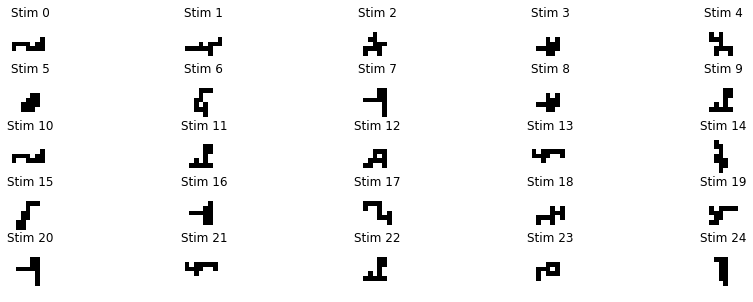

In [ ]:
# plot a few stims as they will appear in the experiment
# plot_idx = np.sort(np.random.choice(n_sim,25,False))
plot_idx = np.arange(25)

if do_plot:
  mkPlot_subplots(final_Sil,plot_idx,10,'Stim ',5,5)

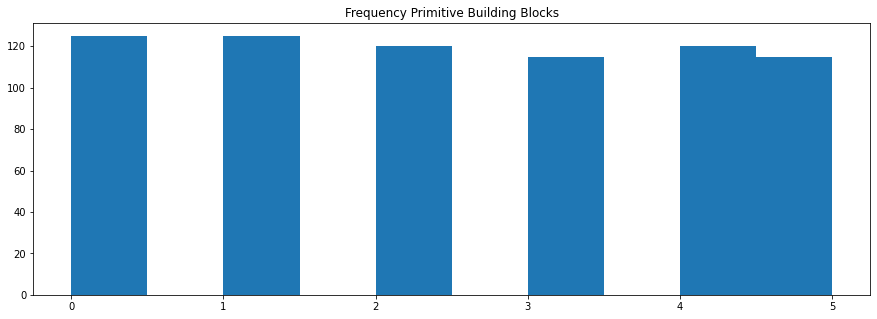

In [ ]:
# histogram for building block distribution
if do_plot:
  plt.hist(solutions.flatten())
  plt.title('Frequency Primitive Building Blocks')
  plt.show()

In [ ]:
# save stims as CSVs
# coord_Blocks_csv = np.reshape(coord_Blocks,(-1,4))

# np.savetxt("Block_coordinates.csv", coord_Blocks_csv, delimiter=",",
#            fmt='%s',header="X,Y,ID,Trial", comments='')

# np.savetxt("Solutions.csv", solutions, delimiter=",",
#            fmt='%s',header="Block 1,Block 2,Block 3,Block 4", comments='')

# np.savetxt("Trialtype.csv", trial_type, delimiter=",",
#            fmt='%s',header="Trialtype", comments='')

# np.savetxt("Stim_ID.csv", stims_use, delimiter=",",
#            fmt='%s',header="StimID", comments='')